In [31]:
import pandas as pd
DATA_PATH = "D:\dataScience\data"
with open(DATA_PATH+r"\stopwords.txt",'r') as file:
    stopwords=file.read()
amazon_df=pd.read_csv(DATA_PATH+r"\Amazon.csv",encoding = "ISO-8859-1")
google_df=pd.read_csv(DATA_PATH+r"\Google.csv",encoding = "ISO-8859-1")

In [32]:
perfectMap_df=pd.read_csv(DATA_PATH+r"\Amazon_Google_perfectMapping.csv")
perfectMap=[]
def buildPerfectMap(x): perfectMap.append((x['idAmazon'],x['idGoogleBase']))
perfectMap_df.apply(buildPerfectMap,axis=1)

pass

In [33]:
import re
stopwords = stopwords.split('\n')
split_regex = r'\w+'
# TODO Implement this
def simple_tokenize(string):
    string=string.lower()
    return re.findall(split_regex,string)
def tokenize(string):
    if not type(string) is str:return []
    xx=simple_tokenize(string)
    for i in stopwords:
        while i in xx:
            xx.remove(i)
    return xx

def rec2tok(x,dic):
    #x:a record from on DataFrame
    #dic:dictionary that build mappings from record id to tokens
    if not type(x['description']) is str:x['description']=''
    if not type(x['manufacturer']) is str:x['manufacturer']=''
    dic[x['id']]=tokenize(x['title']+' '+x['description']+' '+x['manufacturer'])

In [34]:
def inc(i,dic):
    #i:a key in dic
    #dic:dic[i]++
    if i in dic: dic[i]+=1
    else: dic[i]=1
    
def tf(tokens):
    tfs={}
    for i in tokens: inc(i,tfs)            
    n=float(len(tokens))
    for i in tfs:tfs[i]/=n
    return tfs
def idf(rec2tok):
    idfs={}
    N=float(len(amazon_df)+len(google_df))
    for i in rec2tok:
        s=set(rec2tok[i])
        for j in s:inc(j,idfs)
    for i in idfs:idfs[i]=N/idfs[i]
    return idfs
def tfidf(tokens,idfs):
    ans=tf(tokens)
    s=set(tokens)
    for i in ans:
        ans[i]*=idfs[i]
    return ans 

def invertIndex(forward_index):
    #return a mapping from token to list-of-record-IDs
    ans={}
    for i in forward_index:
        for j in forward_index[i]:
            if j in ans:ans[j].append(i)
            else: ans[j]=[i]
    return ans


In [61]:
import math

# Optional utility
def dotprod(a, b):
    ans=0
    for i in a:
        if i in b: ans+=a[i]*b[i]
  
    return ans

# Optional utility
def norm(a):
    ans=0
    for i in a:
        ans+=a[i]**2
    return math.sqrt(ans)

In [62]:
amazon_rec2tok = {}
google_rec2tok = {}

amazon_df.apply(lambda x:rec2tok(x,amazon_rec2tok),axis=1)
google_df.apply(lambda x:rec2tok(x,google_rec2tok),axis=1)

amazon_inv=invertIndex(amazon_rec2tok)

In [63]:
from collections import Counter
idfs_full = dict(Counter(idf(amazon_rec2tok))+Counter(idf(google_rec2tok)))
google_weights={i:tfidf(google_rec2tok[i],idfs_full) for i in google_rec2tok}
amazon_weights={i:tfidf(amazon_rec2tok[i],idfs_full) for i in amazon_rec2tok}
google_norm={i:norm(google_weights[i]) for i in google_weights}
amazon_norm={i:norm(amazon_weights[i]) for i in amazon_weights}

In [64]:
def buildSim(Id,weight,norm,weights,norms,inv,sims):
    #weights : Id->token->weight
    #norms : Id->norm
    for i in weight:
        if i in inv:
            for j in inv[i]:
                if not (j,Id) in sims: sims[(j,Id)]=dotprod(weight,weights[j])/norm/norms[j]

In [65]:
sims={}
for i in google_weights:
    buildSim(i,google_weights[i],google_norm[i],amazon_weights,amazon_norm,amazon_inv,sims)

In [66]:
print (len(sims))# Should be 2441100

2440794


In [67]:
true_dup_sims = []
def truepos(threshold):
    global true_dup_sims
    true_dup_sims=[]
    for i in sims:
        if sims[i]>threshold: 
            true_dup_sims.append(i)
def bin(similarity):
    return int(similarity * nthresholds)

# TODO Implement this
def falsepos(threshold):
    ans=0
    for i in true_dup_sims:
        if not i in perfectMap: ans+=1
    return ans


# TODO Implement this (returns a float)
def precision(threshold):
    truepos(threshold)
    a=len(true_dup_sims)-falsepos(threshold)
    b=len(true_dup_sims)
    return a*1.0/b

In [68]:
nthresholds=100
thresholds = [float(n) / nthresholds for n in range(2, nthresholds)]
p=[precision(n) for n in thresholds]


Populating the interactive namespace from numpy and matplotlib
最大准确率阈值 0.81
最大准确率： 0.6394849785407726


D:\ANACONDA\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


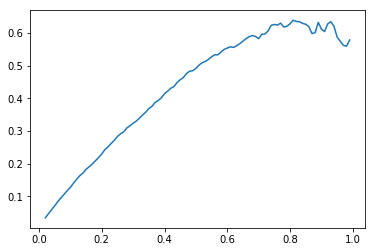

In [69]:
%pylab inline
plt.plot(thresholds,p)
for i in range(0,98):
    if p[i]==max(p): print ("最大准确率阈值",thresholds[i])
    
print ("最大准确率：",max(p))